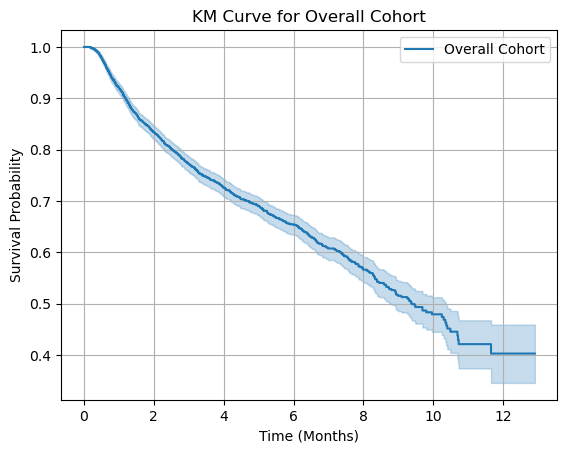

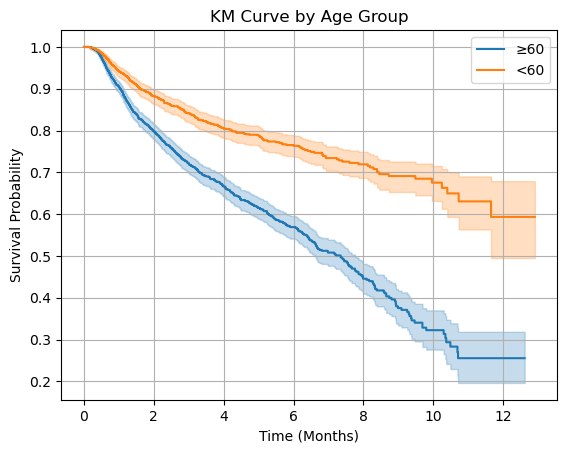

Log-Rank Test p-value (AgeGroup): 3.182830178437243e-31


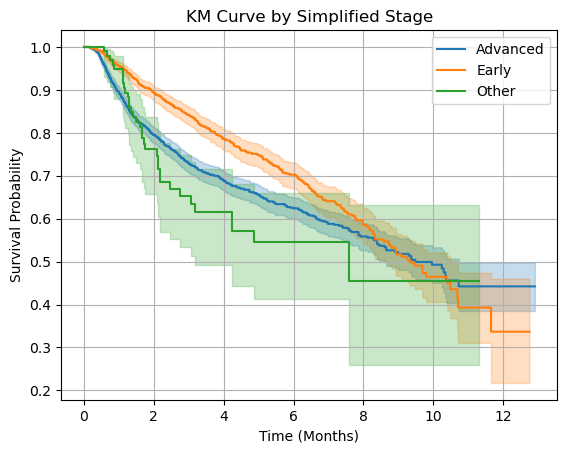

Log-rank test only for 2 groups (found 3)
Log-Rank Test p-value (Simplified Stage): None


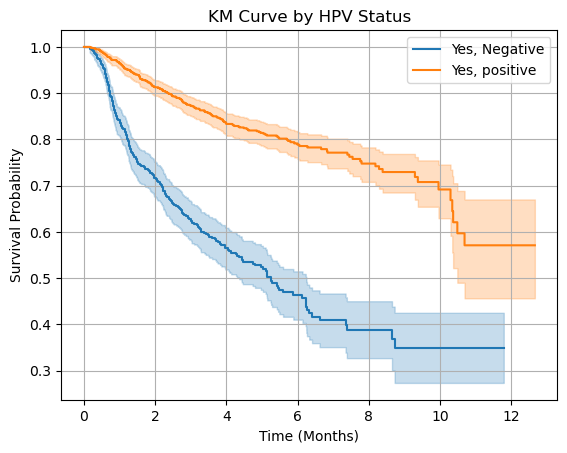

Log-Rank Test p-value (HPV Status): 6.3430122437302e-42

--- HPV Status Check ---
HPV
NaN              1629
Yes, positive    1139
Yes, Negative     578
Name: count, dtype: int64
Missing: 1629 (48.7%)

HPV analyzed with KM only — excluded from Cox/RSF to avoid >50% data loss and preserve model validity.
Cox Model Coefficients: [  0.03779759  -0.72001429  -0.27239316 -10.86355313   1.6947301
   0.56037003   0.64703289]
Cox Model Concordance Index: 0.6606034786231452


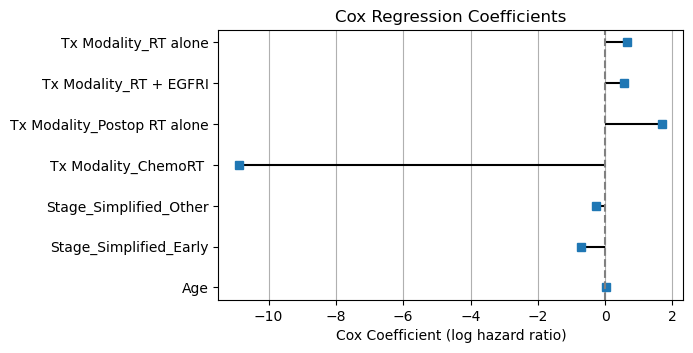

Random Survival Forest Concordance Index: 0.6017812409940366


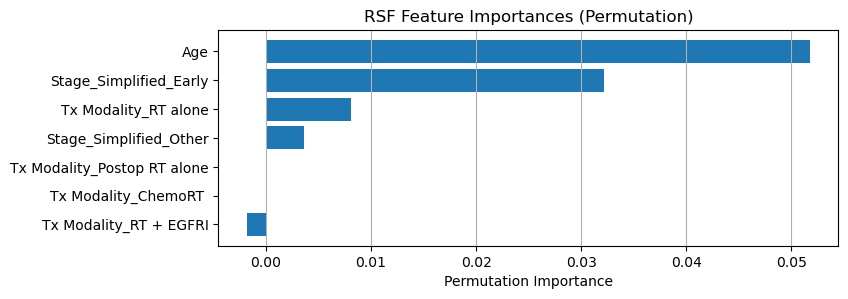


--- Model Comparison ---
Kaplan-Meier Log-Rank Test p-value (AgeGroup): 3.182830178437243e-31
Kaplan-Meier Log-Rank Test p-value (HPV Status): 6.3430122437302e-42
Kaplan-Meier Log-Rank Test p-value (Simplified Stage): None
Cox PH Concordance Index: 0.6606034786231452
Random Survival Forest Concordance Index: 0.6017812409940366


In [ ]:
#1. Import Libraries — essential Python libraries for survival analysis, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.linear_model import CoxPHSurvivalAnalysis  # For Cox Proportional Hazards model
from sksurv.ensemble import RandomSurvivalForest  # For Random Survival Forest model
from sksurv.metrics import concordance_index_censored  # For model evaluation metric (C-index)
from sklearn.inspection import permutation_importance  # For assessing feature importance in RSF

import data_preprocessor as dp  # Custom preprocessing functions we created earlier

#2. Load, Clean, and Preprocess Data
df = dp.load_and_clean_data("../Data/RADCURE_Clinical_v04_20241219.csv")  # Clean missing data, impute values
df = dp.create_age_group(df)  # Categorize patients into AgeGroup (<60 or ≥60)
df = dp.simplify_stage(df)  # Simplify clinical stage into Early/Advanced/Other groups

#3. Kaplan-Meier (KM) Survival Curves and Log-Rank Tests

# KM for Overall Cohort — gives the overall survival probability curve
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
plt.figure()
kmf.fit(df['Length FU'], df['Status'].apply(lambda x: 1 if x == 'Dead' else 0), label='Overall Cohort')
kmf.plot_survival_function()
plt.title('KM Curve for Overall Cohort')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

# KM by Age Group — stratifies survival by age and compares with log-rank test
km_data_age = dp.get_km_groups(df, 'AgeGroup')
dp.plot_km(km_data_age, title="KM Curve by Age Group")
p_value_age = dp.perform_logrank_test(km_data_age)
print(f"Log-Rank Test p-value (AgeGroup): {p_value_age}")

# KM by Simplified Stage — looks at how survival varies by disease stage
km_data_stage = dp.get_km_groups(df, 'Stage_Simplified')
dp.plot_km(km_data_stage, title="KM Curve by Simplified Stage")
p_value_stage = dp.perform_logrank_test(km_data_stage)
print(f"Log-Rank Test p-value (Simplified Stage): {p_value_stage}")

# KM by HPV Status — evaluates survival based on HPV status
km_data_hpv = dp.get_km_groups(df, 'HPV')
dp.plot_km(km_data_hpv, title="KM Curve by HPV Status")
p_value_hpv = dp.perform_logrank_test(km_data_hpv)
print(f"Log-Rank Test p-value (HPV Status): {p_value_hpv}")
# Check HPV missing values before modeling
hpv_counts = df['HPV'].value_counts(dropna=False)
total = len(df)
missing = hpv_counts.get(np.nan, 0)
print("\n--- HPV Status Check ---")
print(hpv_counts)
print(f"Missing: {missing} ({missing/total:.1%})")
print("\nHPV analyzed with KM only — excluded from Cox/RSF to avoid >50% data loss and preserve model validity.")

#4. Cox Proportional Hazards Model — assesses how covariates impact the hazard of death over time
cox_vars = ['Age', 'Stage_Simplified', 'Tx Modality']  # Predictor variables
X, y = dp.prepare_cox_data(df, cox_vars)  # Prepare input features and survival outcome

cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(X, y)

print("Cox Model Coefficients:", cox_model.coef_)
cindex_cox = concordance_index_censored(y["event"], y["time"], cox_model.predict(X))[0]
print(f"Cox Model Concordance Index: {cindex_cox}")

# Visualize Cox Coefficients — forest plot to show impact of each covariate
plt.figure(figsize=(6, len(cox_model.coef_) * 0.5))
plt.hlines(y=range(len(cox_model.coef_)), xmin=0, xmax=cox_model.coef_, color='black')
plt.plot(cox_model.coef_, range(len(cox_model.coef_)), 's')
plt.yticks(range(len(cox_model.coef_)), X.columns)
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Cox Coefficient (log hazard ratio)')
plt.title('Cox Regression Coefficients')
plt.grid(axis='x')
plt.show()

#5. Random Survival Forest (RSF) Model with Permutation Importance
X_train, X_test, y_train, y_test = dp.split_data(X, y)  # Split into training and testing sets

rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15,
                            max_features="sqrt", n_jobs=-1, random_state=42)
rsf.fit(X_train, y_train)

cindex_rsf = concordance_index_censored(y_test["event"], y_test["time"], rsf.predict(X_test))[0]
print(f"Random Survival Forest Concordance Index: {cindex_rsf}")

# Feature Importance using Permutation — shows which variables most influenced RSF predictions
perm_result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = perm_result.importances_mean
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, len(sorted_idx) * 0.4))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('RSF Feature Importances (Permutation)')
plt.grid(True, axis='x')
plt.show()

#6. Summary of Model Results
print("\n--- Model Comparison ---")
print(f"Kaplan-Meier Log-Rank Test p-value (AgeGroup): {p_value_age}")
print(f"Kaplan-Meier Log-Rank Test p-value (HPV Status): {p_value_hpv}")
print(f"Kaplan-Meier Log-Rank Test p-value (Simplified Stage): {p_value_stage}")
print(f"Cox PH Concordance Index: {cindex_cox}")
print(f"Random Survival Forest Concordance Index: {cindex_rsf}")
